In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import datetime

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
df = pd.read_csv("data_dt.csv")

In [4]:
df.head()

,DateTime,Voltage,Current,Power,Inv_Temp
0,7/19/2019 6:20,220,45,23,26
1,7/19/2019 6:25,218,59,32,26
2,7/19/2019 6:30,225,68,44,26
3,7/19/2019 6:35,227,82,53,25
4,7/19/2019 6:40,229,105,69,26


In [5]:
df.values.shape

(26112, 5)

In [6]:
df['year'] = df.DateTime.map( lambda x: pd.to_datetime(x).year )
df['hour'] = df.DateTime.map( lambda x: pd.to_datetime(x).hour )
df['dayofyear'] = df.DateTime.map( lambda x: pd.to_datetime(x).dayofyear )
df['month'] = df.DateTime.map( lambda x: pd.to_datetime(x).month )
df['minute'] = df.DateTime.map( lambda x: pd.to_datetime(x).minute )

In [7]:
del df['DateTime']
df.head()

,Voltage,Current,Power,Inv_Temp,year,hour,dayofyear,month,minute
0,220,45,23,26,2019,6,200,7,20
1,218,59,32,26,2019,6,200,7,25
2,225,68,44,26,2019,6,200,7,30
3,227,82,53,25,2019,6,200,7,35
4,229,105,69,26,2019,6,200,7,40


In [8]:
shift_days = 1
shift_steps = shift_days * 142

In [9]:
target_names = ['Power']

In [10]:
df_targets = df[target_names].shift(-shift_steps)

In [11]:
df[target_names].head(shift_steps + 5)

,Power
0,23
1,32
2,44
3,53
4,69
5,85
6,99
7,115
8,129
9,144


In [12]:
df_targets.head(5)

,Power
0,38.0
1,50.0
2,78.0
3,64.0
4,63.0


In [13]:
df_targets.tail()

,Power
26107,NaN
26108,NaN
26109,NaN
26110,NaN
26111,NaN


In [14]:
x_data = df.values[0:-shift_steps]

In [15]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 9)


In [16]:
y_data = df_targets.values[:-shift_steps]

In [17]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 1)


In [18]:
num_data = len(x_data)
num_data

25970

In [19]:
train_split = 0.9

In [20]:
num_train = int(train_split * num_data)
num_train

23373

In [21]:
num_test = num_data - num_train
num_test

2597

In [22]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

25970

In [23]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

25970

In [24]:
num_x_signals = x_data.shape[1]
num_x_signals

9

In [25]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [26]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0
Max: 2020


In [27]:
x_scaler = MinMaxScaler()

In [28]:
x_train_scaled = x_scaler.fit_transform(x_train)

C:\Users\idfor\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000004


In [30]:
x_test_scaled = x_scaler.transform(x_test)

In [31]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [32]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(23373, 9)
(23373, 1)


In [33]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [34]:
batch_size = 256

In [35]:
sequence_length = 142 * 7 * 8
sequence_length

7952

In [36]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [37]:
x_batch, y_batch = next(generator)

In [38]:
print(x_batch.shape)
print(y_batch.shape)

(256, 7952, 9)
(256, 7952, 1)


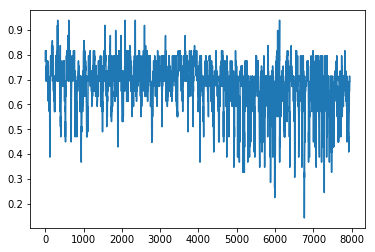

In [39]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

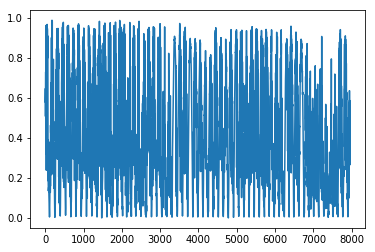

In [40]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [41]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [42]:
model = Sequential()

In [43]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [44]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [45]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [46]:
warmup_steps = 50

In [47]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [48]:
optimizer = RMSprop(lr=1e-3)

In [49]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         801792    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 802,305
Trainable params: 802,305
Non-trainable params: 0
_________________________________________________________________


In [51]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [54]:
#callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        #patience=5, verbose=1)

In [55]:
#callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                  # histogram_freq=0,
                                  # write_graph=False)

In [56]:
""""callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [57]:
""""callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
"""works till here and then my laptop cant process fast enough!!"""
model.fit_generator(generator,
          epochs=1,
          steps_per_epoch=100,
          validation_data=validation_data)

Epoch 1/1


In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

In [ ]:
print("loss (test-set):", result)

In [ ]:
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [ ]:
plot_comparison(start_idx=100000, length=1000, train=True)